In [4]:

!pip install xgboost joblib textblob folium geopy



In [12]:
import pandas as pd
path = "/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz"
df = pd.read_csv(path)
df.shape, df.columns[:10]


((459, 79),
 Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
        'description', 'neighborhood_overview', 'picture_url', 'host_id'],
       dtype='object'))

In [13]:
# Cell 1 - Mount Drive and set constants
from google.colab import drive
drive.mount('/content/drive')

DRIVE = "/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz"
DATA_DIR = DRIVE + "/data"
NOTEBOOKS_DIR = DRIVE + "/notebooks"
FIGURES_DIR = DRIVE + "/figures"
MODELS_DIR = DRIVE + "/models"

# create folders (idempotent)
!mkdir -p "{DATA_DIR}" "{NOTEBOOKS_DIR}" "{FIGURES_DIR}" "{MODELS_DIR}"

print("Drive base:", DRIVE)
RAW_PATH1 = DATA_DIR + "/listings.csv.gz"
RAW_PATH2 = "/content/drive/MyDrive/listings.csv.gz"  # fallback common location
print("Expected raw paths:\n ", RAW_PATH1, "\n ", RAW_PATH2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz’: Not a directory
mkdir: cannot create directory ‘/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz’: Not a directory
mkdir: cannot create directory ‘/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz’: Not a directory
mkdir: cannot create directory ‘/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz’: Not a directory
Drive base: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz
Expected raw paths:
  /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data/listings.csv.gz/data/listings.csv.gz 
  /content/drive/MyDrive/listings.csv.gz


In [14]:
# Cell 2
!pip install -q xgboost joblib textblob folium geopy imbalanced-learn


In [15]:
# Cell 3
import os, pandas as pd, numpy as np
data_path = RAW_PATH1 if os.path.exists(RAW_PATH1) else (RAW_PATH2 if os.path.exists(RAW_PATH2) else None)
if data_path is None:
    raise FileNotFoundError("Could not find listings.csv.gz. Put it in Drive at:\n" + RAW_PATH1 + "\nor\n" + RAW_PATH2)
print("Loading from:", data_path)
df = pd.read_csv(data_path, compression='gzip', low_memory=False)
print("Loaded DataFrame shape:", df.shape)
df.head(3)


Loading from: /content/drive/MyDrive/listings.csv.gz
Loaded DataFrame shape: (459, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2992450,https://www.airbnb.com/rooms/2992450,20250804133828,2025-08-04,city scrape,Luxury 2 bedroom apartment,The apartment is located in a quiet neighborho...,NaN,https://a0.muscache.com/pictures/44627226/0e72...,4621559,...,4.56,3.22,3.67,NaN,f,1,1,0,0,0.07
1,3820211,https://www.airbnb.com/rooms/3820211,20250804133828,2025-08-04,city scrape,Funky Urban Gem: Prime Central Location - Park...,Step into the charming and comfy 1BR/1BA apart...,Overview<br /><br />The lovely apartment is lo...,https://a0.muscache.com/pictures/prohost-api/H...,19648678,...,4.81,4.81,4.77,NaN,f,4,4,0,0,2.32
2,5651579,https://www.airbnb.com/rooms/5651579,20250804133828,2025-08-04,city scrape,Large studio apt by Capital Center & ESP@,"Spacious studio with hardwood floors, fully eq...",The neighborhood is very eclectic. We have a v...,https://a0.muscache.com/pictures/b3fc42f3-6e5e...,29288920,...,4.88,4.76,4.64,NaN,f,2,1,1,0,2.97


In [16]:
# Cell 4
display(df.dtypes.value_counts())
print("\nFirst 10 columns & dtypes:")
display(df.dtypes[:10])

missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.concat([missing, missing_pct], axis=1)
missing_df.columns = ['missing_count', 'missing_pct']
display(missing_df.head(60))


,count
object,34
int64,26
float64,19



First 10 columns & dtypes:


,0
id,int64
listing_url,object
scrape_id,int64
last_scraped,object
source,object
name,object
description,object
neighborhood_overview,object
picture_url,object
host_id,int64


,missing_count,missing_pct
license,459,100.00
calendar_updated,459,100.00
neighbourhood_group_cleansed,459,100.00
neighbourhood,263,57.30
neighborhood_overview,263,57.30
host_about,208,45.32
host_location,114,24.84
host_neighbourhood,70,15.25
last_review,68,14.81
first_review,68,14.81


In [17]:
# Cell 5 -
df['price_raw'] = df.get('price')  # keep original
df['price'] = df['price'].astype(str).str.replace(r'[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

print("Null prices after cleaning:", df['price'].isna().sum())
print("Min/Max before filtering:", df['price'].min(), df['price'].max())

# remove non-positive or NaN prices
before = len(df)
df = df[df['price'].notna() & (df['price'] > 0)].copy()
print(f"Removed {before - len(df)} rows with missing/non-positive price. Remaining rows: {len(df)}")

# quick quantiles to understand outliers
display(df['price'].quantile([0.01,0.05,0.25,0.5,0.75,0.95,0.99]))


Null prices after cleaning: 40
Min/Max before filtering: 24.0 1050.0
Removed 40 rows with missing/non-positive price. Remaining rows: 419


,price
0.01,35.18
0.05,46.00
0.25,70.50
0.50,95.00
0.75,127.00
0.95,260.70
0.99,549.78


In [18]:
# Cell 6 -
date_cols = ['host_since','first_review','last_review']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

print("Parsed date coverage:")
for c in date_cols:
    if c in df.columns:
        print(c, "non-null:", df[c].notna().sum())


Parsed date coverage:
host_since non-null: 419
first_review non-null: 366
last_review non-null: 366


In [22]:
import os

# Correct main paths
DRIVE = "/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7"
DATA_DIR = os.path.join(DRIVE, "data")
FIGURES_DIR = os.path.join(DRIVE, "figures")

# Create the folders if they don’t exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print("✅ DRIVE set to:", DRIVE)
print("✅ DATA_DIR set to:", DATA_DIR)
print("✅ FIGURES_DIR set to:", FIGURES_DIR)


✅ DRIVE set to: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7
✅ DATA_DIR set to: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/data
✅ FIGURES_DIR set to: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures


In [23]:
import os

print("drive exists:", os.path.exists(DRIVE), "isdir?", os.path.isdir(DRIVE))
print("data_dir exists:", os.path.exists(DATA_DIR), "isdir?", os.path.isdir(DATA_DIR))
print("figures_dir exists:", os.path.exists(FIGURES_DIR), "isdir?", os.path.isdir(FIGURES_DIR))

# list contents of week7
!ls -lh "/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7"


drive exists: True isdir? True
data_dir exists: True isdir? True
figures_dir exists: True isdir? True
total 20K
drwx------ 2 root root 4.0K Oct 10 19:34 data
drwx------ 2 root root 4.0K Oct 10 19:33 figures
drwx------ 2 root root 4.0K Oct 10 19:33 models
drwx------ 2 root root 4.0K Oct 10 19:33 notebooks
drwx------ 2 root root 4.0K Oct 10 19:33 scripts


✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/price_hist_clipped.png


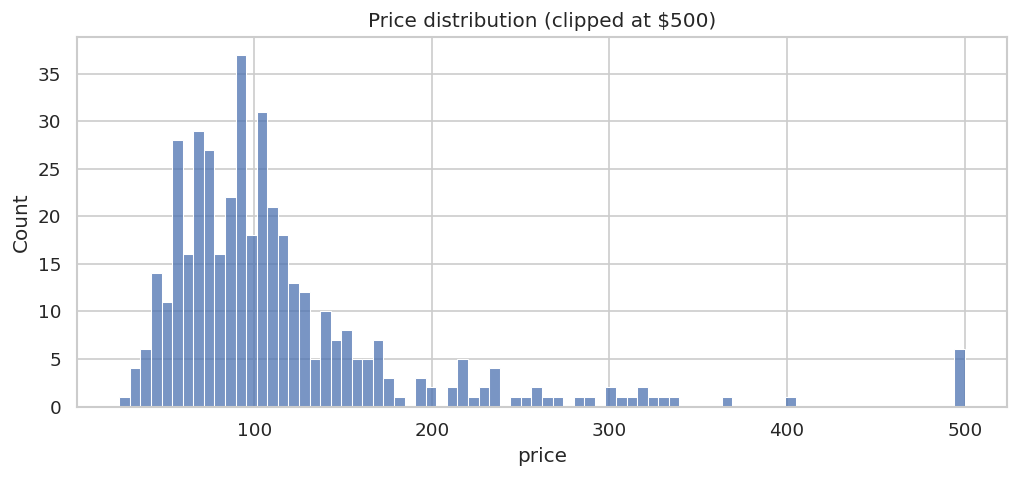

✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/price_log_hist.png


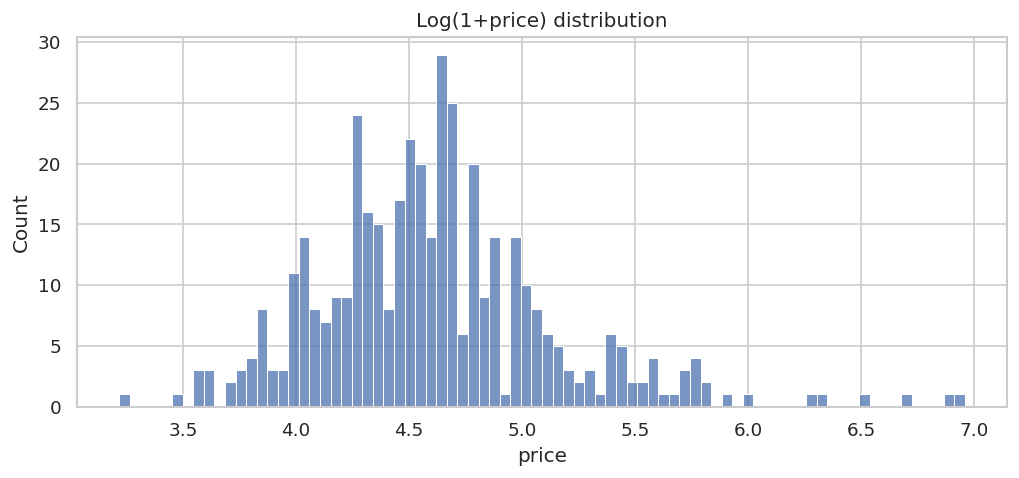

✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/price_by_room_type.png


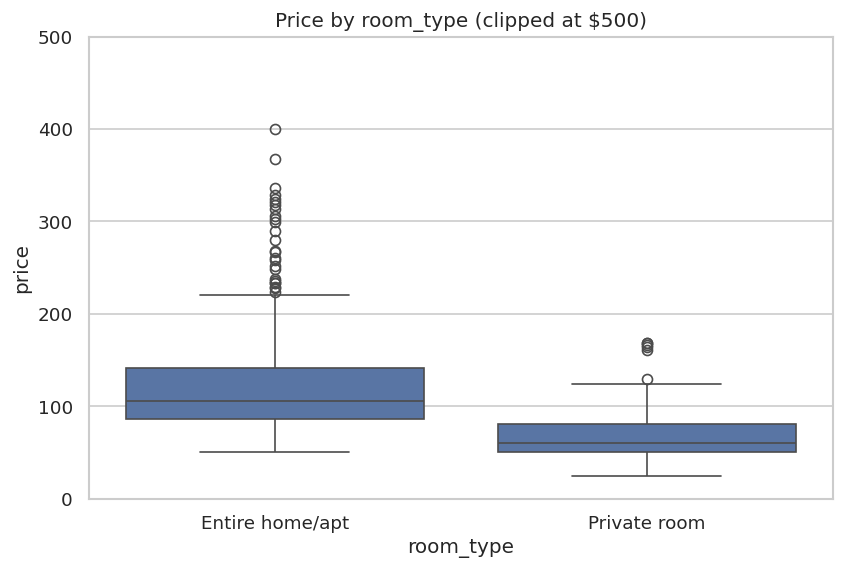

✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/geo_price_scatter.png


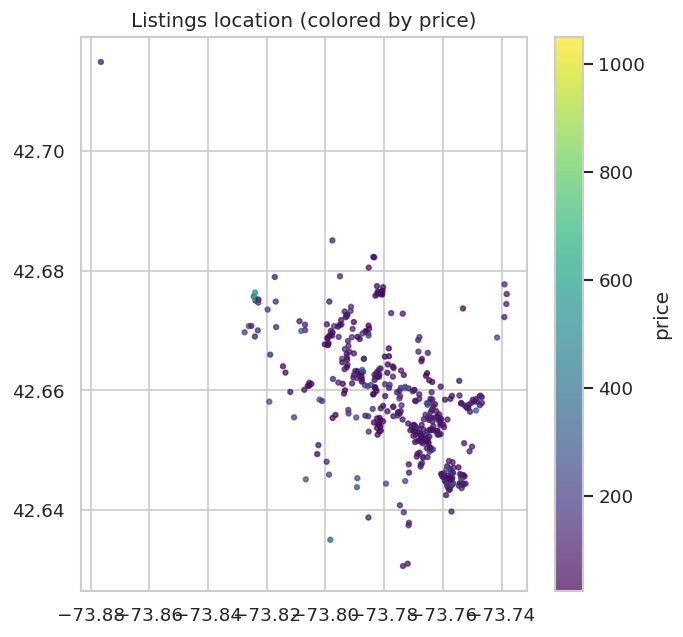

✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/reviews_hist.png


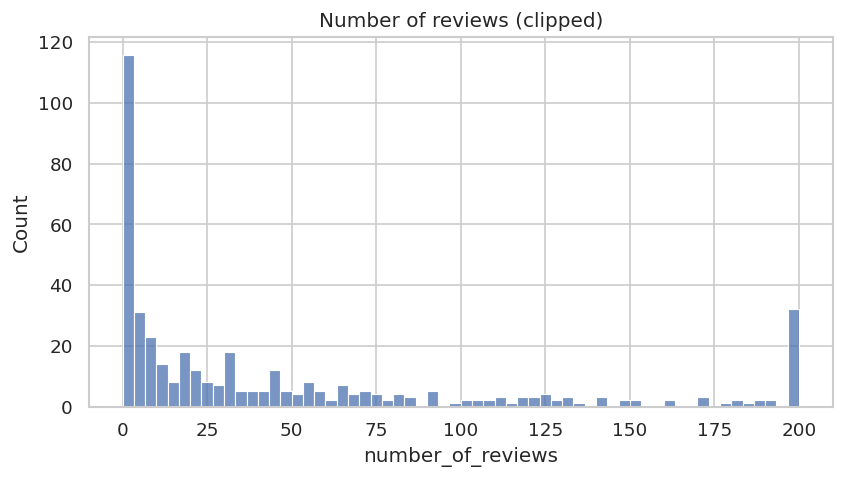

✅ Saved figure: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/figures/numeric_corr_heatmap.png


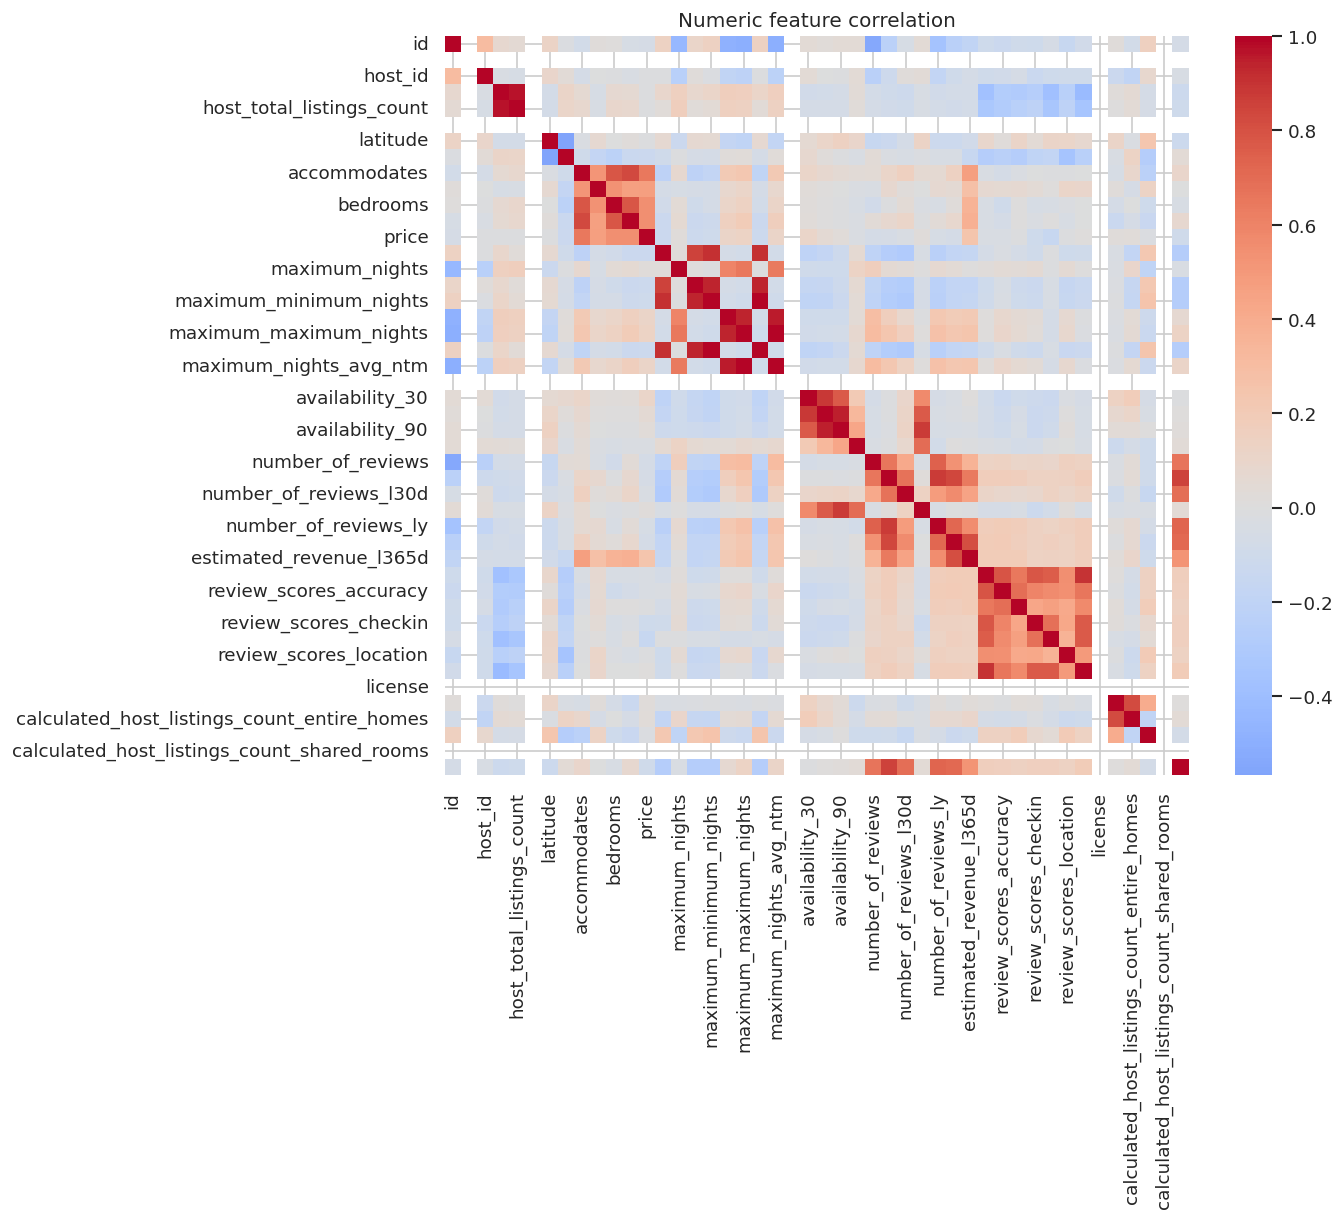

In [24]:
# --- Visualization setup and save function ---
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

def save_fig(fig, name):
    """Save figure safely to your figures folder."""
    path = os.path.join(FIGURES_DIR, name)
    fig.savefig(path, bbox_inches='tight')
    print("✅ Saved figure:", path)


# --- 1) Price histogram (clipped at $500) ---
fig = plt.figure(figsize=(10,4))
sns.histplot(df['price'].clip(upper=500), bins=80)
plt.title("Price distribution (clipped at $500)")
save_fig(fig, "price_hist_clipped.png")
plt.show()

# --- 2) Log(1+price) histogram ---
fig = plt.figure(figsize=(10,4))
sns.histplot(np.log1p(df['price']), bins=80)
plt.title("Log(1+price) distribution")
save_fig(fig, "price_log_hist.png")
plt.show()

# --- 3) Boxplot price by room_type (if exists) ---
if 'room_type' in df.columns:
    fig = plt.figure(figsize=(8,5))
    sns.boxplot(x='room_type', y='price', data=df)
    plt.ylim(0, 500)
    plt.title("Price by room_type (clipped at $500)")
    save_fig(fig, "price_by_room_type.png")
    plt.show()

# --- 4) Geospatial scatter if longitude/latitude exist ---
if 'longitude' in df.columns and 'latitude' in df.columns:
    fig = plt.figure(figsize=(6,6))
    sc = plt.scatter(df['longitude'], df['latitude'],
                     c=df['price'], s=8, cmap='viridis', alpha=0.7)
    plt.colorbar(sc, label='price')
    plt.title("Listings location (colored by price)")
    save_fig(fig, "geo_price_scatter.png")
    plt.show()

# --- 5) Number of reviews histogram ---
if 'number_of_reviews' in df.columns:
    fig = plt.figure(figsize=(8,4))
    sns.histplot(df['number_of_reviews'].clip(upper=200), bins=60)
    plt.title("Number of reviews (clipped)")
    save_fig(fig, "reviews_hist.png")
    plt.show()

# --- 6) Correlation heatmap for numeric columns ---
num_cols = df.select_dtypes(include='number').columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    fig = plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title("Numeric feature correlation")
    save_fig(fig, "numeric_corr_heatmap.png")
    plt.show()


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Select useful columns
keep_cols = ['price','latitude','longitude','number_of_reviews','room_type','minimum_nights']
df = df[keep_cols].dropna()

# Feature / target split
y = df['price']
X = df.drop(columns=['price'])

# Identify categorical + numeric
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

# One-hot encode categoricals
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[cat_cols]) if cat_cols else np.empty((len(X),0))
X_cat_df = pd.DataFrame(X_cat, columns=ohe.get_feature_names_out(cat_cols))

# Scale numerics
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_cols])
X_num_df = pd.DataFrame(X_num, columns=num_cols)

# Combine back
X_final = pd.concat([X_num_df.reset_index(drop=True),
                     X_cat_df.reset_index(drop=True)], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print("✅ X_train:", X_train.shape, "X_test:", X_test.shape)


✅ X_train: (335, 5) X_test: (84, 5)


In [26]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name:15s} | MSE={mse:.2f} | R2={r2:.3f}")


LinearRegression | MSE=8606.92 | R2=0.128
Ridge           | MSE=8607.99 | R2=0.128
RandomForest    | MSE=9215.31 | R2=0.066


In [27]:
import joblib
import pandas as pd
import os

# Save models
for name, model in models.items():
    model_path = os.path.join(DRIVE, "models", f"{name}.pkl")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(model, model_path)
    print("✅ Saved:", model_path)

# Save evaluation results
results_df = pd.DataFrame(results).T.round(3)
results_path = os.path.join(DRIVE, "models", "evaluation_results.csv")
results_df.to_csv(results_path)
print("\n📊 Saved evaluation results to:", results_path)
display(results_df)


✅ Saved: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/models/LinearRegression.pkl
✅ Saved: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/models/Ridge.pkl
✅ Saved: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/models/RandomForest.pkl

📊 Saved evaluation results to: /content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7/models/evaluation_results.csv


,MSE,R2
LinearRegression,8606.923,0.128
Ridge,8607.992,0.128
RandomForest,9215.310,0.066


In [28]:
from tensorflow import keras
from tensorflow.keras import layers

dl_model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

dl_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = dl_model.fit(X_train, y_train, validation_split=0.2,
                       epochs=20, batch_size=32, verbose=1)

test_loss, test_mae = dl_model.evaluate(X_test, y_test)
print(f"✅ Deep model test MAE={test_mae:.2f}")

dl_model.save(os.path.join(DRIVE, "models", "deep_model.keras"))


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 26362.1406 - mae: 118.6653 - val_loss: 12849.1992 - val_mae: 104.4570
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24945.9590 - mae: 116.6971 - val_loss: 12760.7939 - val_mae: 104.0212
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 28330.2871 - mae: 117.9611 - val_loss: 12666.9375 - val_mae: 103.5559
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 36673.9492 - mae: 126.2719 - val_loss: 12560.4414 - val_mae: 103.0244
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18243.4355 - mae: 108.7948 - val_loss: 12434.8857 - val_mae: 102.3952
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21710.8711 - mae: 112.9885 - val_loss: 12276.7891 - val_mae: 101.5990
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22483.5859 - mae: 111.3422 - val_loss: 12085.4375 - val_mae: 100.6266
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22133.8652 - mae: 109.2205 - val_loss: 11849.6328 - val_mae:

In [29]:
print("=== WEEK 7 SUMMARY REPORT ===")
print(f"Total samples: {len(df)}")
print("\nModel performance comparison:")
display(results_df)

print("\nDeep learning MAE:", round(test_mae,2))
print("\nAll artifacts saved to Drive folder:")
print(DRIVE)


=== WEEK 7 SUMMARY REPORT ===
Total samples: 419

Model performance comparison:


,MSE,R2
LinearRegression,8606.923,0.128
Ridge,8607.992,0.128
RandomForest,9215.310,0.066



Deep learning MAE: 77.42

All artifacts saved to Drive folder:
/content/drive/MyDrive/Buildable-ML-DL-Fellowship/week7
